Iteration 100 completed


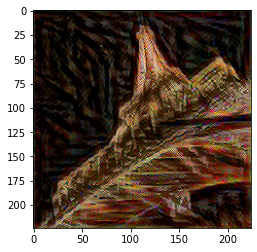

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def vgg19(input_shape=(224, 224, 3)):
    model = tf.keras.Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Classifier
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1000, activation='softmax'))  # Output layer, adjust units for your task
    
    return model


input_shape = (224, 224, 3)
model = vgg19(input_shape)

# Function to preprocess the image for VGG19
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# Function to deprocess the image for viewing
def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Load the content and style images
content_image = preprocess_image('./images/eiffel.jpg')
style_image = preprocess_image('./images/thescream.jpg')


# Define the layers to use for the style and content
content_layer = 'block5_conv2'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Create the model for content and style
outputs = [model.get_layer(name).output for name in style_layers + [content_layer]]
style_model = Model(inputs=model.input, outputs=outputs)

# Function to compute content loss
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# Function to compute the gram matrix for style loss
def gram_matrix(input_tensor):
    # We have to make sure the input tensor is a 2D matrix for the Gram matrix calculation
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

# Compute the style features' Gram matrices
style_grams = [gram_matrix(style_feature) for style_feature in style_outputs]


# Function to compute style loss
def style_loss(base_style, gram_target):
    # Unpack the dimensions, including the batch size
    batch_size, height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    
    # Normalize the style loss by the number of elements in each feature map
    return tf.reduce_mean(tf.square(gram_style - gram_target)) / (height * width * channels)


# Extract the style and content features
style_outputs = style_model(style_image)
content_outputs = style_model(content_image)

# Set initial image for optimization
initial_image = tf.Variable(content_image, dtype=tf.float32)

# Define the optimizer
optimizer = tf.optimizers.Adam(learning_rate=5.0)

# Modify the style loss calculation in the optimization loop
for i in range(1, 101):
    with tf.GradientTape() as tape:
        output = style_model(initial_image)
        # Compute the style loss using the Gram matrices
        loss = sum([style_loss(output[j], style_grams[j]) for j in range(len(style_layers))])
        loss += content_loss(output[-1], content_outputs[-1])
    grad = tape.gradient(loss, initial_image)
    optimizer.apply_gradients([(grad, initial_image)])
    if i % 100 == 0:
        print(f'Iteration {i} completed')

# Display the final image
plt.imshow(deprocess_image(initial_image.numpy()[0]))
plt.show()


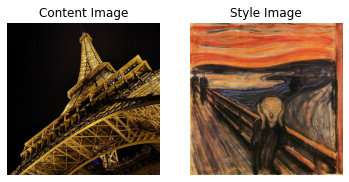

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define a function to display images
def display_images(content_img_path, style_img_path):
    # Load images
    content_image = mpimg.imread(content_img_path)
    style_image = mpimg.imread(style_img_path)

    # Display content image
    plt.subplot(1, 2, 1)
    plt.imshow(content_image)
    plt.title('Content Image')
    plt.axis('off')

    # Display style image
    plt.subplot(1, 2, 2)
    plt.imshow(style_image)
    plt.title('Style Image')
    plt.axis('off')

    # Show the images
    plt.show()

# Paths to the images
content_img_path = './images/eiffel.jpg'
style_img_path = './images/thescream.jpg'

# Display the images
display_images(content_img_path, style_img_path)
